In [1]:
import sys
sys.path.append('../utils')

import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans

The main goals of this notebook are:

1. To demonstrate how to inspect backscatter images.
2. Introduce the use [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) unsupervised clustering algorithm to classify pixels in SAR images. For those unfamiliar with K-means - here is a nice [video](https://www.youtube.com/watch?v=0MQEt10e4NM) explaining the algorithm in detail. We will be using the sklearn library, which has very good [documentation](https://scikit-learn.org/stable/modules/clustering.html#k-means) about the algorithm and its use.

# Inspecting the Data

In [2]:
data_dir = Path('../data')
backscatter_tifs = sorted(list(data_dir.glob('./*backscatter*.tif')))
backscatter_tifs

[PosixPath('../data/alos_backscatter_hh.tif'),
 PosixPath('../data/alos_backscatter_hv.tif')]

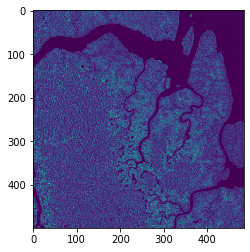

In [3]:
with rasterio.open(backscatter_tifs[0]) as ds:
    hh = ds.read(1)
plt.imshow(hh)

Above, the images are in linear $\gamma^0$ and have been [radiometrically terrain corrected](https://www.asf.alaska.edu/sar-information/alos-palsar-radiometric-terrain-correction/) (RTC). We will not have the time to discuss the details of this processing of backscatter images. Fortunately, the products viewed above can be obtained for download directly from [HyP3](http://hyp3.asf.alaska.edu/) or the ASF [vertex](https://search.asf.alaska.edu/#/). 

If you cannot obtain RTC images directly, there are ways of processing lower level radar data using open source software such as ISCE2. [Here](https://github.com/isce-framework/isce2/blob/8d42d4d429b28039d2c9982e611db8f6206fcab2/README.md#rtcappxml) is an example for Sentinenel-2. Additionally, such correction can be accomplished using [SNAP](https://step.esa.int/main/toolboxes/snap/) as discussed in this excellent, detailed [tutorial](https://gis1.servirglobal.net/TrainingMaterials/SAR/chp6_training_E.pdf) by Dr. Marc Simard.

For this tutorial, this is what we need to know:

1. $\gamma^0$ is typically used for forest and biomass analysis
2. Radiometric and terrain correction tries to remove incidence angle dependence and layovers. A more detailed account of this correction can be found in David Small's [paper](http://www.geo.uzh.ch/microsite/rsl-documents/research/publications/peer-reviewed-articles/201108-TGRS-Small-tcGamma-3809999360/201108-TGRS-Small-tcGamma.pdf).

# Decibels

As microwave remote sensing is an active remote sensing, it is frequently advantageous to view these images in decibels. Frequently, the dynamic range of a backscatter image is reported in dB. Also, noise in linear $\gamma$ is multiplicative. In dB, however, the becomes additive as

$$
\log(I \cdot \varepsilon) = \log(I) + \log(\varepsilon)
$$
where $I$ is the image and $\varepsilon$ is the noise.

Finding the dB image requires only one line of code.

In [4]:
hh_db = 10 * np.log10(hh)

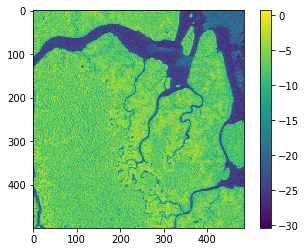

In [5]:
plt.imshow(hh_db)
plt.colorbar()

We can look at the histograms of backscatters in dB.

Text(0.5, 0, '$\\gamma^0$ (db)')

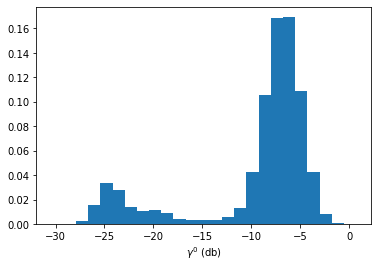

In [6]:
plt.hist(hh_db.ravel(),
         bins=25,
         density=True)
plt.xlabel('$\gamma^0$ (db)')

Let's now do the sam for HV polarization.

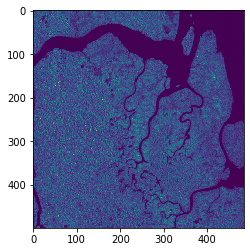

In [7]:
with rasterio.open(backscatter_tifs[1]) as ds:
    hv = ds.read(1)
plt.imshow(hv)

In [8]:
hv_db = 10 * np.log10(hv)

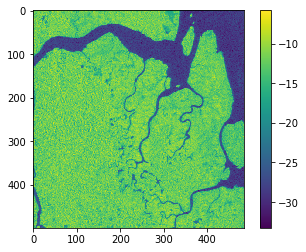

In [9]:
plt.imshow(hv_db)
plt.colorbar()

We can compare the two images in a histogram.

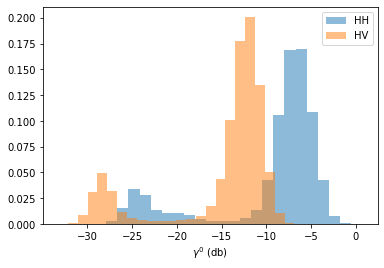

In [10]:
plt.hist(hh_db.ravel(),
         bins=25,
         density=True,
         label='HH',
         # alpha is the transparency
         alpha=.5)
plt.hist(hv_db.ravel(),
         bins=25,
         density=True,
         label='HV',
         # alpha is the transparency
         alpha=.5)
plt.xlabel('$\gamma^0$ (db)')
plt.legend()

# Classifying Pixels

[Classification](https://en.wikipedia.org/wiki/Statistical_classification) is an important portion of statistics and machine learning. Roughly, given a dataset $\mathcal D$, classification wishes to learn the mapping $f$ into some set of finite labels $L$ so that $f: \mathcal D \to L$. In our case, our dataset $\mathcal D$ consists of the pixel backscatter values that is $\mathcal D = \{ \gamma^0_{ij} \; : \; i=1, ..., M,\; j = 1,... N\}$ and our labels $L$ could be landcover classes such as mangroves, water, etc.

We will focus on K-means because this is unsupervised. This simply means we do not use pre-existing knowledge of the label mapping to improve performance. We have chosen an unsupervised approach because it is very easy to apply and a good way to get a sense of what information is present in the SAR image.

Let's start with the easiest scenario, namely, looking only at HH backscatter. We know that water tends to have low HH backscatter in SAR image (discussed [here](https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/ers/instruments/sar/applications/radar-courses/content-2/-/asset_publisher/qIBc6NYRXfnG/content/radar-course-2-parameters-affecting-radar-backscatter)). So, we can start looking at thresholds to determine classes of 0 (land) and 1 (water).

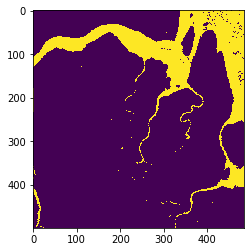

In [11]:
plt.imshow((hh_db < -18).astype(int))

We can also use the distribution of the HH backscatter to determine this automatically with K-means.

In [12]:
model = KMeans(# How many classes we want - in this case, just water and land
               n_clusters=2, 
               # this ensures the models output is the same each time,
               random_state=0)

model.fit(hh_db.reshape((-1,1)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

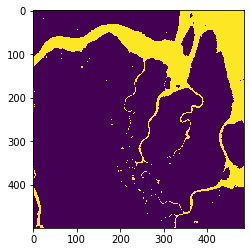

In [13]:
classes = model.labels_.reshape(hh_db.shape)
plt.imshow(classes)

# Excercise 1

Plot thresholds from -30 to -10 for some integer stepsize and see how the land/water threshold partitions the image. Write one these classifcations as a GeoTIFF and see how it looks in QGIS using a basemap.

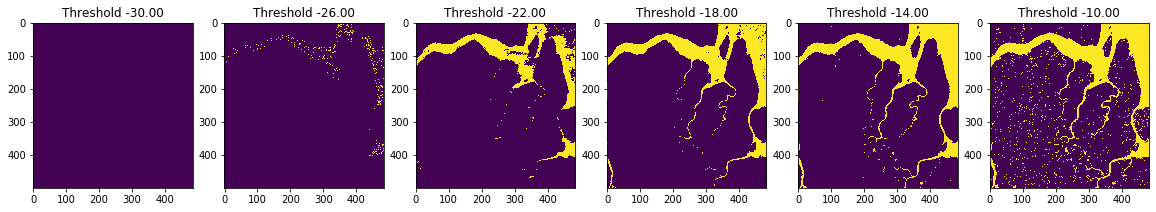

In [14]:
## Answer
N=6
thresh_arr = np.linspace(-30, -10, N)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for ax, thresh in zip(ax.ravel(), thresh_arr):
    ax.imshow(hh_db < thresh)
    ax.set_title(f'Threshold {thresh:1.2f}')

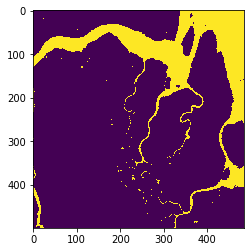

In [15]:
## Answer

X = (hh_db < -15).astype(np.uint8)
plt.imshow(X)

In [16]:
with rasterio.open(backscatter_tifs[0]) as ds:
    profile = ds.profile

profile['nodata'] = None
profile['dtype'] = 'uint8'
with rasterio.open('threshold.tif', 'w', **profile) as ds:
    ds.write(X, 1)

# Excercise 2

Apply K-means to pixels with *HH and HV* and divide the image into *3* classes. How does it do?

Write your classes to a file and inspect the results.

In [17]:
## Answer

model_2 = KMeans(n_clusters=3, 
                 random_state=0)
X_train = np.zeros((hh.size, 2))
X_train[:, 0] = hh_db.ravel()
X_train[:, 1] = hv_db.ravel()
model_2.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

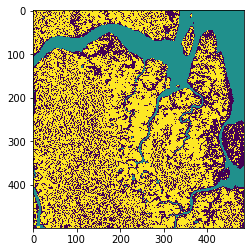

In [18]:
## Answer

classes_2 = model_2.labels_.reshape(hh_db.shape)
plt.imshow(classes_2)

Text(0, 0.5, 'HV (db)')

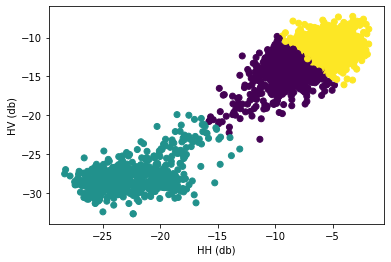

In [19]:
## Answer

N = 4000
indices = np.random.choice(np.arange(hh_db.size), N)
plt.scatter(hh_db.ravel()[indices], hv_db.ravel()[indices], c=classes_2.ravel()[indices])
plt.xlabel('HH (db)')
plt.ylabel('HV (db)')

In [20]:
## Answer

with rasterio.open(backscatter_tifs[0]) as ds:
    profile = ds.profile

profile['nodata'] = None
profile['dtype'] = 'uint8'
with rasterio.open('kmeans.tif', 'w', **profile) as ds:
    ds.write(classes_2.astype(np.uint8), 1)

# Acknowledgements

We gratefully and humbly acknowledge JAXA for the use of ALOS-2 data to generate a coherence image over Mondah, Gabon generated using ISCE2.

We are grateful to the ASF for providing easy access to ALOS-1 radiometrically and terrain corrected tiles over Mondah and Ko Panyi.

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.